# Library Imports

In [45]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical
from pypfopt.efficient_frontier import EfficientFrontier
import time
import multiprocessing as mp
#import test
from sklearn import linear_model



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

In [5]:
tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')
stocks

,GE,PFE,SBUX,GME,DAL,AAPL,GOOGL
Date,,,,,,,
2007-05-04,-0.005088,0.007816,-0.029095,-0.010122,0.012548,0.004084,-0.004459
2007-05-07,0.002423,0.011078,-0.011401,0.001805,-0.029552,0.030850,-0.008172
2007-05-08,-0.004297,-0.001096,-0.005601,0.004503,-0.035854,0.010970,-0.000984
2007-05-09,0.004854,0.003696,-0.004639,0.001195,0.008151,0.017324,0.005227
2007-05-10,-0.012883,-0.013255,-0.016644,-0.017313,-0.004548,0.004304,-0.016580
...,...,...,...,...,...,...,...
2021-04-13,-0.011038,0.005139,0.013619,-0.000709,-0.011471,0.024307,0.004370
2021-04-14,0.017857,0.000269,-0.001734,0.181148,-0.001865,-0.017853,-0.005554
2021-04-15,-0.009503,0.011568,0.013025,-0.060590,-0.028026,0.018708,0.019332


# Manual Get_Weights Function

In [6]:
def get_weights(r0, mean, std, covar):
   
    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = len(mean)
    mean = mean.values.reshape((n,1))
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((n, 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

# Manual_Weights Algorithm (Rolling)

In [7]:
days = 20
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]:
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    r0 = mean.median()
    r0s.append([r0])
    std = sample.std(axis=0)
    covar = sample.cov()
    weights_vector = get_weights(r0, mean, std, covar)
    portfolio = pd.concat([stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector), portfolio])
    saved_weights.append(weights_vector.flatten())
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)


## Manual_Weights Testing and Analysis 

In [8]:
n = len(tickers)
equal_weights = stocks.dot(np.ones((n,1))/n)

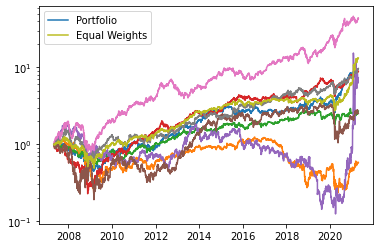

In [9]:

plt.plot((1+portfolio).cumprod(), label = 'Portfolio')
plt.plot((1+stocks).cumprod())
plt.plot((1+equal_weights).cumprod(), label = 'Equal Weights')
plt.yscale("log")
plt.legend()

In [10]:
empyrical.sharpe_ratio(stocks).max()

0.9952872272742871

In [11]:
empyrical.sharpe_ratio(equal_weights)

array([0.82002595])

In [12]:
empyrical.sharpe_ratio(portfolio)


array([0.68083264])

## Parameter Search
1. Median, Window_Size = 20, Tickers = ["GE", "PFE", "Starbucks], Sharpe:0.75383353 vs. 0.7161903905293208
2. Median, Window_Size = 20, Tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ], Sharpe:  .68083264 vs .81624048

# Efficient Frontier (Historical Data)

In [13]:
mu = stocks.mean()
sigma = stocks.cov()


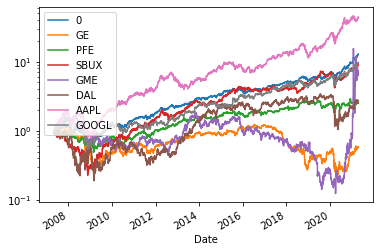

In [14]:
Ef = EfficientFrontier(mu, sigma)
weight_vector = Ef.efficient_return(mu.median())
weight_list = [weight_vector[ticker] for ticker in stocks.columns]
portfolio = stocks.dot(weight_list)
dataframe = pd.concat([portfolio, stocks], axis=1)
(1 + dataframe).cumprod().plot()
plt.yscale("log")

In [15]:
empyrical.sharpe_ratio(dataframe)

array([0.9508793 , 0.06830673, 0.42497747, 0.65366001, 0.54000953,
       0.39282189, 0.99528723, 0.69889944])

In [16]:
empyrical.sharpe_ratio(portfolio)

0.9508792995546791

In [17]:
weight_vector

OrderedDict([('GE', 0.0),
             ('PFE', 0.3983233455859337),
             ('SBUX', 0.1288584358267634),
             ('GME', 0.0433381680309546),
             ('DAL', 0.0),
             ('AAPL', 0.2748872079994545),
             ('GOOGL', 0.1545928425568938)])

In [18]:
days = 20
sampled_means = stocks.resample(str(days)+"d").mean()
sampled_covars = [sample[1].cov() for sample in stocks.resample(str(days)+"d")]

In [19]:
weight_dicts = [EfficientFrontier(mean,cov).min_volatility() for mean, cov in zip(sampled_means.values,sampled_covars)]

# Efficient Frontier Algorithm (rolling)

In [20]:
days = 5
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]: 
    sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    covar = sample.cov()
    weights_vector = [EfficientFrontier(mean,covar).max_quadratic_utility()[ticker] for ticker in stocks.columns]
    portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
    saved_weights.append(weights_vector)
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)

## Efficient Frontier Testing and Analysis

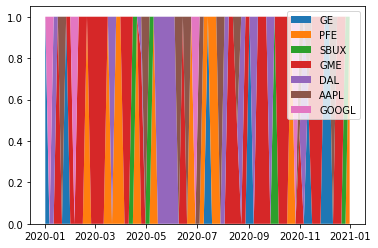

In [21]:
plt.stackplot(saved_weights['2020':'2020'].index, *(saved_weights[ticker]['2020':'2020'] for ticker in saved_weights.columns), labels=saved_weights.columns)
plt.legend()

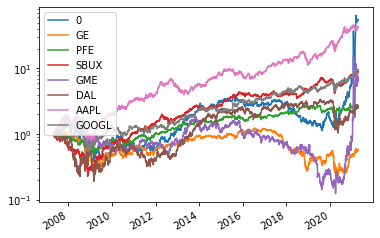

In [22]:
(1+pd.concat([portfolio,stocks],axis=1)).cumprod().plot()
plt.yscale('log')

In [23]:
empyrical.sharpe_ratio(pd.concat([portfolio,stocks],axis=1))

array([0.69328654, 0.06830673, 0.42497747, 0.65366001, 0.54000953,
       0.39282189, 0.99528723, 0.69889944])

In [24]:
saved_weights.sum(axis=1).max()

1.0000085190055645

In [25]:
def Mean_Variance_Rolling(days):
    X = stocks.resample(str(days)+"d").mean()
    dates = X.index[1:-1]
    portfolio = pd.DataFrame()

    saved_weights = []
    r0s = []

    for day in dates[:-1]:
        #sample = stocks[day:day+pd.offsets.DateOffset(days = (days-1))]
        sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

        mean = sample.mean(axis=0)
        covar = sample.cov()
        weights_vector = [EfficientFrontier(mean,covar).min_volatility()[ticker] for ticker in stocks.columns]
        portfolio = pd.concat([portfolio,stocks[day+pd.offsets.DateOffset(days = days):day+pd.offsets.DateOffset(days=((2*days)-1))].dot(weights_vector)])
        saved_weights.append(weights_vector)
    portfolio = portfolio.sort_index()
    saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)
    return portfolio
sample


,GE,PFE,SBUX,GME,DAL,AAPL,GOOGL
Date,,,,,,,
2021-04-05,0.013554,-0.000551,0.014994,-0.023505,0.029080,0.023577,0.041873
2021-04-06,-0.004458,-0.006340,0.019186,-0.013105,0.027861,0.002462,-0.004371
2021-04-07,-0.000746,-0.003883,0.000354,-0.035393,-0.028074,0.013390,0.013475
2021-04-08,0.004481,0.001392,-0.001325,-0.043322,-0.007769,0.019234,0.005091
2021-04-09,0.011152,0.017798,0.001238,-0.069893,-0.010841,0.020252,0.008994


In [26]:
#start_time = time.time()
#with mp.Pool(mp.cpu_count()) as p:
#    all_portfolios = p.map(Mean_Variance_Rolling, range(10,15))
#print(time.time() - start_time)

In [27]:
import test

In [28]:
start_time = time.time()
y = test.run_test(tickers,stocks,range(5,255))
print(time.time() - start_time)

274.1303746700287


In [ ]:
max([empyrical.sharpe_ratio(i) for i in y])

# empyrical.sharpe_ratio(stocks).max()

In [ ]:
empyrical.sharpe_ratio(stocks.mean(axis=1))

In [ ]:
start_time = time.time()
y = [x+1 for x in range(10000)]
print(time.time() - start_time)

# Sharpe Ratio Correlation

In [90]:
days = 21
X = stocks.resample(str(days)+"d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

sharpe_ratios = []


for day in dates[:-1]: 
    sample = stocks["AAPL"][day:day+pd.offsets.DateOffset(days = (days-1))]
    sharpe_ratios.append(empyrical.calmar_ratio(sample))

sharpe_ratios_dataframe = pd.DataFrame(index = dates[:-1], columns = ["AAPL"], data = sharpe_ratios)


In [75]:
X

array([[   0.,   21.,   42.,   63.,   84.,  105.,  126.,  147.,  168.,
         189.,  210.,  231.,  252.,  273.,  294.,  315.,  336.,  357.,
         378.,  399.,  420.,  441.,  462.,  483.,  504.,  525.,  546.,
         567.,  588.,  609.,  630.,  651.,  672.,  693.,  714.,  735.,
         756.,  777.,  798.,  819.,  840.,  861.,  882.,  903.,  924.,
         945.,  966.,  987., 1008., 1029., 1050., 1071., 1092., 1113.,
        1134., 1155., 1176., 1197., 1218., 1239., 1260., 1281., 1302.,
        1323., 1344., 1365., 1386., 1407., 1428., 1449., 1470., 1491.,
        1512., 1533., 1554., 1575., 1596., 1617., 1638., 1659., 1680.,
        1701., 1722., 1743., 1764., 1785., 1806., 1827., 1848., 1869.,
        1890., 1911., 1932., 1953., 1974., 1995., 2016., 2037., 2058.,
        2079., 2100., 2121., 2142., 2163., 2184., 2205., 2226., 2247.,
        2268., 2289., 2310., 2331., 2352., 2373., 2394., 2415., 2436.,
        2457., 2478., 2499., 2520., 2541., 2562., 2583., 2604., 2625.,
      

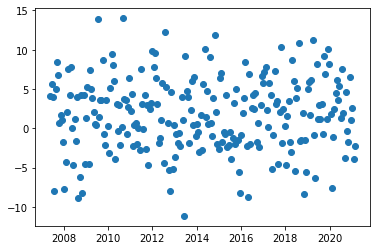

In [44]:
plt.scatter(dates[:-1], sharpe_ratios)


[-0.01154178] 121.1432527134115


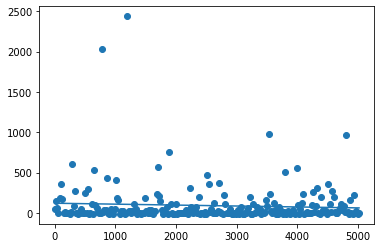

In [91]:
X = np.array((dates[:-1] - dates[:-1].min())  / pd.Timedelta(1,'D')).reshape(-1,1)
Y = np.array(sharpe_ratios).flatten()

model = linear_model.LinearRegression(fit_intercept = True)
model.fit(X,Y)

y_pred = model.predict(X)

plt.plot(X.flatten(), y_pred.flatten())
plt.scatter(X,Y)
print(model.coef_,model.intercept_)